In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

2024-02-17 18:18:35.934109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 18:18:35.959100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 18:18:35.959120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 18:18:35.959803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 18:18:35.963827: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

IMAGES_DIR = '/home/alex/Documents/HackTCNJ/HackTCNJ/dataset/garbage classification/Garbage classification'
    
train_file = '/home/alex/Documents/HackTCNJ/HackTCNJ/dataset/one-indexed-files-notrash_train.txt'
val_file   = '/home/alex/Documents/HackTCNJ/HackTCNJ/dataset/one-indexed-files-notrash_val.txt'
test_file  = '/home/alex/Documents/HackTCNJ/HackTCNJ/dataset/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])

df_train = add_class_name_prefix(df_train, 'path')
df_valid = add_class_name_prefix(df_valid, 'path')
df_test  = add_class_name_prefix(df_test,  'path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


In [3]:
gen = ImageDataGenerator(rescale=1./255)    # rescaling the images between 0 and 1

gen_train = gen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

gen_valid = gen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_gen = gen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [4]:
def build_model(num_classes):
    # Loading pre-trained ResNet model
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    base_model.trainable = False
        
    return model

model = build_model(num_classes=6)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Model training

history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=1
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

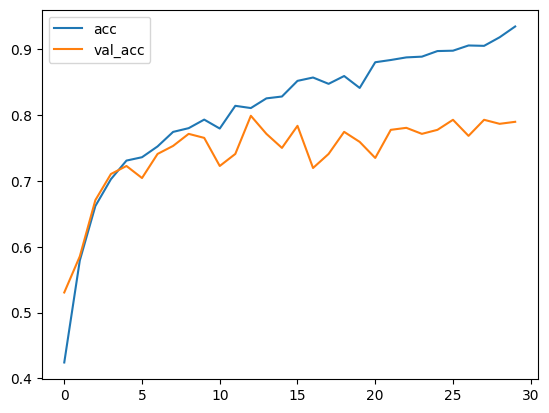

In [9]:
plt.plot(history.history['categorical_accuracy'], label='acc')
plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [10]:

filenames = test_gen.filenames
nb_samples = len(filenames)

model.evaluate_generator(test_gen, nb_samples)

/tmp/ipykernel_14565/1351272730.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen, nb_samples)


[0.602411687374115, 0.7896341681480408]

In [11]:
test_x, test_y = test_gen.__getitem__(1)
preds = model.predict(test_x)

1/1 [==============================] - 2s 2s/step


In [3]:
# Comparing predcitons with original labels

labels = (gen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

NameError: name 'gen_train' is not defined

In [ ]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess the image from URL
def load_and_preprocess_image_from_url(url, target_size=(224, 224)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalize pixel values
    return img_array

# Function to make predictions
def predict_image(model, img_array, gen_train):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    labels = gen_train.class_indices
    labels = {v: k for k, v in labels.items()}
    return labels[predicted_class], prediction

# Function to display the prediction
def display_prediction_from_url(url, model, gen_train):
    img_array = load_and_preprocess_image_from_url(url)
    predicted_class, prediction = predict_image(model, img_array, gen_train)

    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array))
    plt.title('Predicted: {} \nConfidence: {:.2f}%'.format(predicted_class, np.max(prediction)*100))
    plt.axis('off')
    plt.show()

# Example usage
url = input("Enter the URL of the image: ")  # Input the URL of the image
display_prediction_from_url(url, model, gen_train)
